## Jupyter notebook to start cleaning the data for future prediction.

Import libraries that I will use.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from wordcloud import STOPWORDS
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')#Sentence tokenizer


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Joaquin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
dir_data_train = './train.csv'
dir_data_test = './test.csv'

In [10]:
df_test = pd.read_csv(dir_data_test)
df_train = pd.read_csv(dir_data_train)

Lets see a few data.

In [11]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
# As a first model I will throw out the columns keyword and location (because they are mostly in blank). Lets define test target and train variables.
 # Because is a kaggel competition we don't have the test target.

In [13]:
df_train.shape, df_test.shape

((7613, 5), (3263, 4))

Lets see if we have a difference between 0 and 1 target.

In [14]:
df_train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

We will start the cleaning of the twits. First we can look at the twits and visualize the most frequent words.

In [15]:
def gen_freq(text):
    #Will store the list of words
    word_list = []

    #Loop over all the tweets and extract words into word_list
    for tw_words in text.split():
        word_list.extend(tw_words)

    #Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()

    #Print top 20 words
    word_freq[:20]
    
    return word_freq

word_freq = gen_freq(df_train.text.str)

In [16]:
word_freq

the                        2575
a                          1845
to                         1805
in                         1757
of                         1722
                           ... 
https://t.co/NlJVP3Vfyz       1
(Ft.                          1
Dix                           1
bandolier                     1
http://t.co/YmY4rSkQ3d        1
Length: 31924, dtype: int64

We found something that we could imagine, the most frequents words are articles. Lets visualize the data using word clouds.

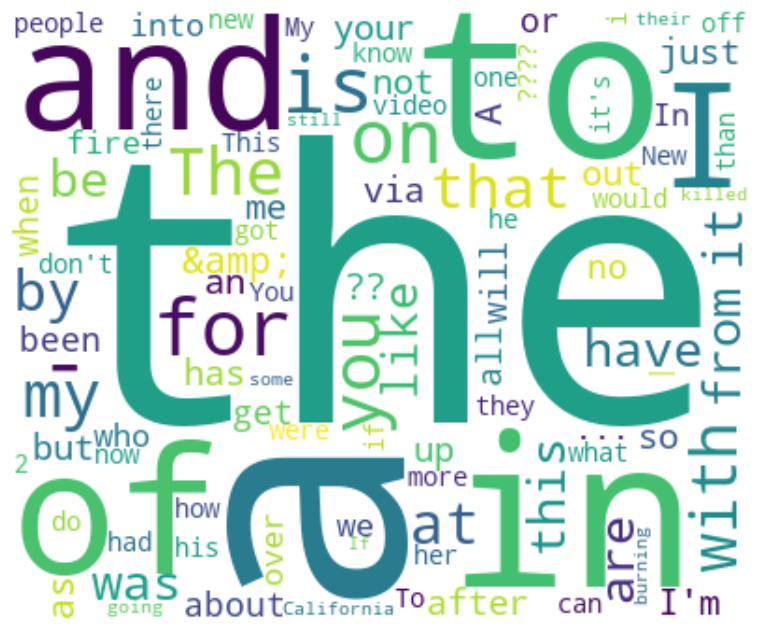

In [17]:
#Generate word cloud
wc = WordCloud(width=400, height=330, max_words=100, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

**Few things to Note:-**

1. There is noise in the form of "&amp" which can be removed from the word frequency.
2. Stop words like "the", "in", "to", "of" etc. are obviously ranking among the top frequency words but these are just constructs of the English language and are not specific to the people's tweets.
3. We can **Normalized** the text.

The above are some of the problems that we need to address in order to make better visualization. Let's solve some of the problems!

In [18]:

#Clean text from noise
def clean_text(text):
    #Filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    #Convert to lowercase to maintain consistency
    text = text.lower()
       
    return text


In [19]:
df_train['clean_text'] = df_train.text.apply(lambda x: clean_text(x))

In [20]:
df_train

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake m...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfires evacuation or...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as ...
...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,aria ahrary thetawniest the out of control w...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m utc km s of volcano hawaii htt...
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an e bike collided ...


In [21]:
from wordcloud import STOPWORDS

#Generate word frequency
def gen_freq_stop_words(text):
    #Will store the list of words
    word_list = []

    #Loop over all the tweets and extract words into word_list
    for tw_words in text.split():
        word_list.extend(tw_words)

    #Create word frequencies using word_list
    word_freq = pd.Series(word_list).value_counts()
    
    #Drop the stopwords during the frequency calculation
    word_freq = word_freq.drop(STOPWORDS, errors='ignore')
    
    return word_freq

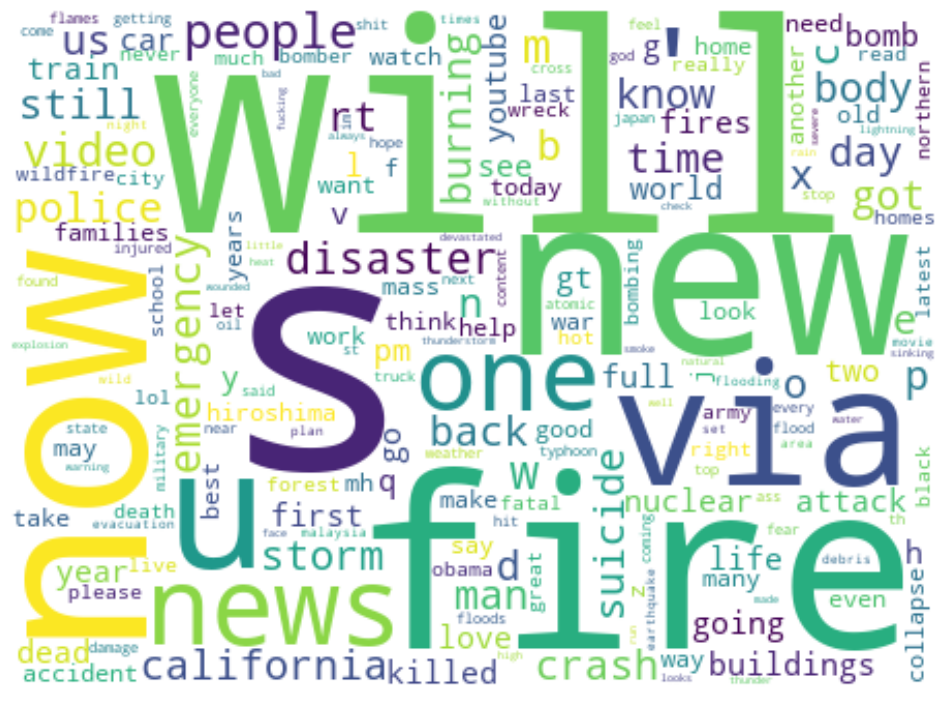

In [24]:
text = df_train.text.apply(lambda x: clean_text(x))
word_freq = gen_freq_stop_words(text.str)*100

#Generate word cloud
wc = WordCloud(width=450, height=330, max_words=200, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 14))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Now we can lemmatize to Normalize.

In [25]:
lemm = WordNetLemmatizer() # Inicialice lemmatizer. 

In [26]:
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: lemm.lemmatize(x))

Now we can try with a very simple model. The idea is to create a bag of words, and then create one array for each twitt, with the length of the size of the bag of words. Then we will put 1 if the word is in the twitt or 0 if itsn't.

In [52]:
bag_of_words = []
for sentence in df_train.clean_text:
    bag_of_words.extend(nltk.word_tokenize(sentence))


In [56]:
'the' in bag_of_words

False

In [57]:
'the' in STOPWORDS

True

Apparentrly we still have stopwords. We lemmatize to normalize and remove stopwords

In [53]:
bag_of_words = [lemm.lemmatize(x) for x in bag_of_words if x not in STOPWORDS]

In [58]:
bag_of_words= set(bag_of_words)

In [59]:
len(bag_of_words)

20998

As this thabase is from a kaggel competition, we dont have the target of the test set, so we will split the training set to see how our moodel perform.